In [2]:
import keras
keras.__version__

'2.4.3'

# CNN para clasificación de textos (F. Chollet)


## Implementing a 1D convnet

In Keras, you would use a 1D convnet via the `Conv1D` layer, which has a very similar interface to `Conv2D`. It takes as input 3D tensors 
with shape `(samples, time, features)` and also returns similarly-shaped 3D tensors. The convolution window is a 1D window on the temporal 
axis, axis 1 in the input tensor.

Let's build a simple 2-layer 1D convnet and apply it to the IMDB sentiment classification task that you are already familiar with.

As a reminder, this is the code for obtaining and preprocessing the data:

In [3]:
from keras.datasets import imdb
from keras.preprocessing import sequence

max_features = 10000  # number of words to consider as features
max_len = 500  # cut texts after this number of words (among top max_features most common words)

print('Loading data...')
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

print('Pad sequences (samples x time)')
x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Loading data...


/home/victor/virtual_env/deep/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/home/victor/virtual_env/deep/lib/python3.8/site-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_test, y_test = np.array(xs[idx:]), np.array(labels[idx:])


25000 train sequences
25000 test sequences
Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)



1D convnets are structured in the same way as their 2D counter-parts: they consist of a stack of `Conv1D` 
and `MaxPooling1D` layers, eventually ending in either a global pooling layer or a `Flatten` layer, turning the 3D outputs into 2D outputs, allowing to add one or more `Dense` layers to the model, for classification or regression.

One difference, though, is the fact that we can afford to use larger convolution windows with 1D convnets. Indeed, with a 2D convolution layer, a 3x3 convolution window contains 3*3 = 9 feature vectors, but with a 1D convolution layer, a convolution window of size 3 would only contain 3 feature vectors. We can thus easily afford 1D convolution windows of size 7 or 9.

This is our example 1D convnet for the IMDB dataset:

In [3]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['acc'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 500, 128)          1280000   
_________________________________________________________________
conv1d (Conv1D)              (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 98, 32)            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
______________________________________________

In [4]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 13s 81ms/step - loss: 0.7374 - acc: 0.5223 - val_loss: 0.6865 - val_acc: 0.5586
Epoch 2/10
157/157 [==============================] - 15s 93ms/step - loss: 0.6687 - acc: 0.6780 - val_loss: 0.6730 - val_acc: 0.5474
Epoch 3/10
157/157 [==============================] - 15s 96ms/step - loss: 0.6297 - acc: 0.7628 - val_loss: 0.6222 - val_acc: 0.7156
Epoch 4/10
157/157 [==============================] - 15s 96ms/step - loss: 0.5495 - acc: 0.8148 - val_loss: 0.5146 - val_acc: 0.8024
Epoch 5/10
157/157 [==============================] - 13s 85ms/step - loss: 0.4302 - acc: 0.8452 - val_loss: 0.4252 - val_acc: 0.8334
Epoch 6/10
157/157 [==============================] - 13s 84ms/step - loss: 0.3510 - acc: 0.8747 - val_loss: 0.4146 - val_acc: 0.8462
Epoch 7/10
157/157 [==============================] - 13s 85ms/step - loss: 0.3076 - acc: 0.8921 - val_loss: 0.3868 - val_acc: 0.8588
Epoch 8/10
157/157 [==============================] - 14s 86ms

Here are our training and validation results: validation accuracy is somewhat lower than that of the LSTM we used two sections ago, but 
runtime is faster, both on CPU and GPU (albeit the exact speedup will vary greatly depending on your exact configuration). At that point, 
we could re-train this model for the right number of epochs (8), and run it on the test set. This is a convincing demonstration that a 1D 
convnet can offer a fast, cheap alternative to a recurrent network on a word-level sentiment classification task.

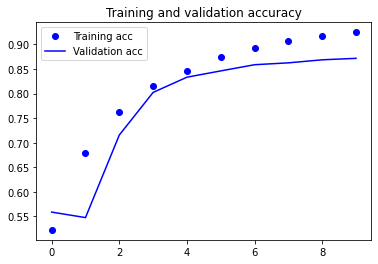

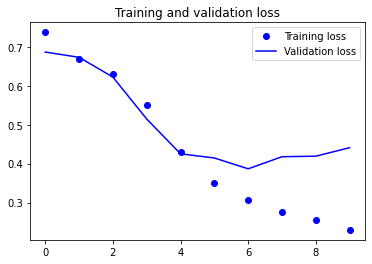

In [5]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()